## AJILE 12 Data

In [17]:
from temporaldata import Data
import h5py
from datetime import timedelta

path = "/home/mila/s/sobralm/brainsets/data/processed/peterson_brunton_pose_trajectory_2022/AJILE12_P01_20000107_ses7_pose_trajectories.h5"
file = h5py.File(path, "r")
data = Data.from_hdf5(file, lazy=True)

### Basic information

In [18]:
print(f"Sampling rate: {data.ecog.sampling_rate} Hz")
print(f"Number of channels: {len(data.channels)}")
duration = timedelta(seconds=(data.ecog.domain.end - data.ecog.domain.start)[0])  
print(f"Duration: {duration} seconds")

Sampling rate: 500.0 Hz
Number of channels: 94
Duration: 0:00:00 seconds


### Plot the data

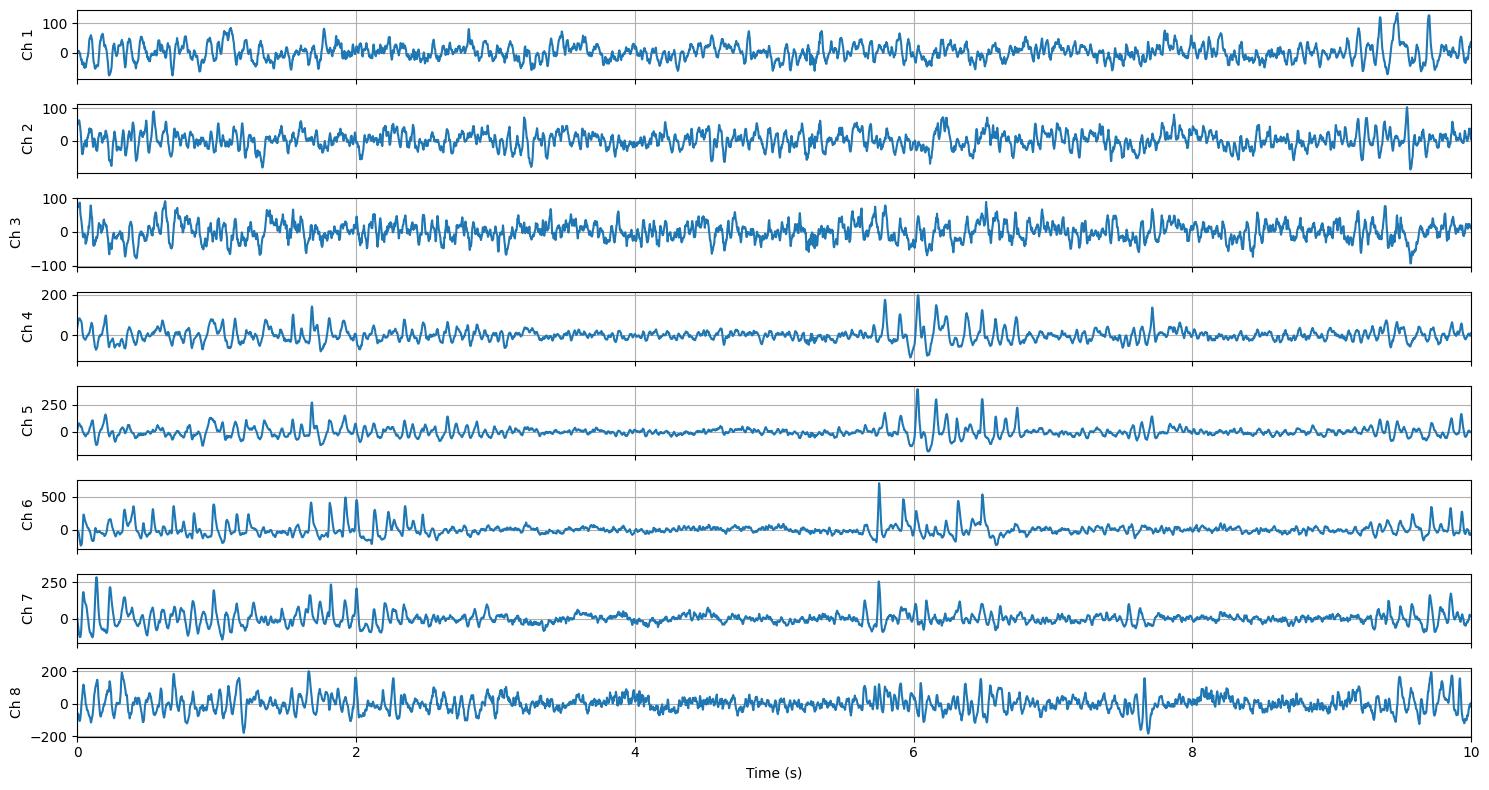

In [74]:
from matplotlib import pyplot as plt
import numpy as np

# Plot 10 seconds of 8 channels in 8 horizontal subplots
sampling_rate = data.ecog.sampling_rate
seconds_to_plot = 10
n_channels_to_plot = 8
start_time = 100
start_time_idx = int(start_time * sampling_rate)
end_time = start_time + seconds_to_plot
end_time_idx = int(end_time * sampling_rate)

fig, axes = plt.subplots(n_channels_to_plot, 1, figsize=(15, 8), sharex=True)
time_axis = (np.arange(end_time_idx - start_time_idx) / sampling_rate)

signal = data.ecog.signal[start_time_idx:end_time_idx, :n_channels_to_plot]

for ch in range(n_channels_to_plot):
    axes[ch].plot(time_axis, signal[:, ch])
    axes[ch].set_ylabel(f"Ch {ch+1}")
    axes[ch].set_xlim([0, seconds_to_plot])
    axes[ch].grid(True)
axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

### Show the pose data

Pose data is stored in the `pose` attribute of the `Data` object.

It contains the following joints:
 * l_ear
 * r_ear
 * l_shoulder
 * r_shoulder
 * l_elbow
 * r_elbow
 * l_wrist
 * r_wrist
 * nose

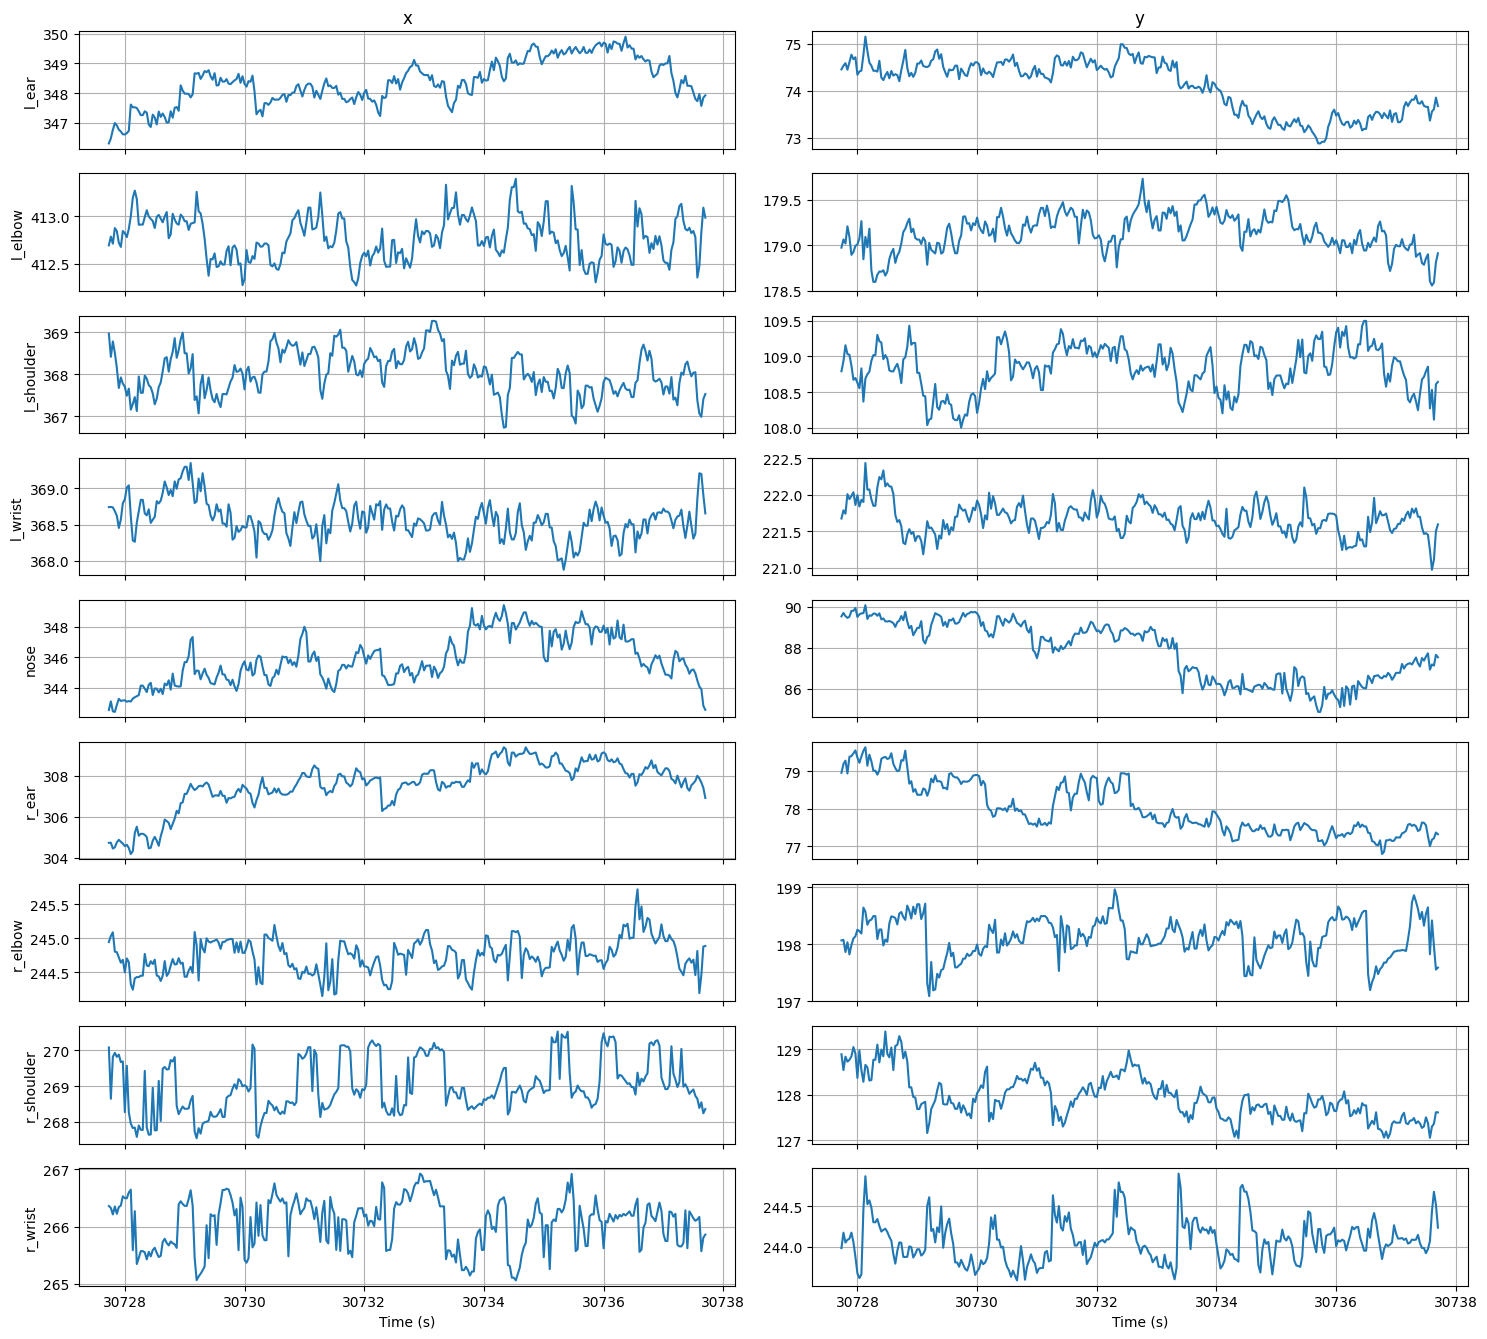

In [75]:
# Plot 10 seconds of each joint, with each row as a joint and columns as x/y
sampling_rate = data.pose.sampling_rate
seconds_to_plot = 10

joints = list(data.pose.keys())
n_joints = len(joints)
coords = ['x', 'y']

fig, axes = plt.subplots(n_joints, 2, figsize=(15, 1.5 * n_joints), sharex=True)
fig.subplots_adjust(hspace=0.5)

# Use pose sampling, not ECoG
# We'll use the first joint (l_ear) to find the first non-nan frame
nan_mask = np.isnan(data.pose.l_ear)
start_index = int(np.where(~nan_mask)[0][0]) + 1000
end_index = start_index + int(seconds_to_plot * sampling_rate)
time_axis = np.arange(start_index, end_index) / sampling_rate

for i, joint in enumerate(joints):
    joint_data = data.pose.__getattribute__(joint)[start_index:end_index]
    for j, coord in enumerate(coords):
        axes[i, j].plot(time_axis, joint_data[:, j])
        if i == 0:
            axes[i, j].set_title(coord)
        if j == 0:
            axes[i, j].set_ylabel(joint)
        axes[i, j].grid(True)
axes[-1, 0].set_xlabel("Time (s)")
axes[-1, 1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()


### Behavior Data (Classification)

There are two types of Behavior Data:
 * Active VS Inactive
 * Task classification: Eat, Talk, TV, Computer/phone, Other activity



In [22]:
behavior = data.behavior_trials
behavior.behavior_labels

array([b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'

In [19]:
import pandas as pd
behavior = data.behavior_trials

print(f"Number of trials in session: {len(behavior.start)}")
print(f"Number of active trials: {np.sum(behavior.active)}")
print(f"Number of inactive trials: {np.sum(~behavior.active)}")

# Compute the number of trials with each of the interesting behaviors
interesting_intervals = behavior.select_by_mask(behavior.active)
unique, counts = np.unique(interesting_intervals.behavior_labels, return_counts=True)
table = pd.DataFrame({"behavior": unique, "count": counts}, index=range(len(unique)))
for index, (u, c) in enumerate(zip(unique, counts)):
    time_in_behavior = sum([end - start for start, end, label in zip(interesting_intervals.start, interesting_intervals.end, interesting_intervals.behavior_labels) if label == u])
    table.loc[index, "time"] = timedelta(seconds=time_in_behavior)
print("Distribution of Active Trials:")
table


Number of trials in session: 920


NameError: name 'np' is not defined

## Exploring the Dataset Class

In [1]:
from brainsets.datasets import PetersonBruntonPoseTrajectory2022

dataset = PetersonBruntonPoseTrajectory2022(
    root="data/processed",
    task_type="pose_estimation",
    split_type="intrasession",
    fold_num=0,
)

In [2]:
intervals = dataset.get_sampling_intervals(split="test")['AJILE12_P01_20000107_ses7_pose_trajectories']
print(intervals)
print(intervals.start)
print(intervals.end)

LazyInterval(
  active=<HDF5 dataset "active": shape (122,), type "|b1">,
  behavior_labels=<HDF5 dataset "behavior_labels": shape (122,), type "|O">,
  end=<HDF5 dataset "end": shape (122,), type "<f8">,
  start=<HDF5 dataset "start": shape (122,), type "<f8">
)
[30694.367 30815.533 32254.733 32493.233 32733.167 32853.833 33092.9
 33214.233 33453.    34293.167 34533.2   35012.967 36817.233 37172.9
 37533.433 37775.5   42212.933 42452.633 42812.933 46533.667 47013.1
 47134.133 47254.533 47734.033 48332.567 48572.433 48694.133 49535.467
 50133.067 50253.1   50612.233 51092.733 51813.1   52052.633 52292.667
 52655.5   52772.767 53492.467 53972.533 54212.433 54694.2   54812.167
 55893.1   56012.433 56252.533 56492.833 56614.333 56852.967 57213.167
 57333.    57812.1   57933.    58412.267 58652.233 59132.033 60572.2
 60932.367 61052.467 61653.1   62012.567 62374.3   62733.067 62972.033
 63332.367 63452.    64411.833 64654.6   64772.2   65012.4   65133.7
 65251.8   65492.267 66092.567 66451